## Support Vector Machines (SVM) for Binary Classification: Breast Cancer Dataset


### 1. Import Required Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

# Set plot style
sns.set(style="whitegrid")

### 2. Load and Explore the Dataset

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

C:\Users\Admin\AppData\Local\Temp\ipykernel_19976\3805525675.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=value_counts.values, palette=colors, edgecolor='black')


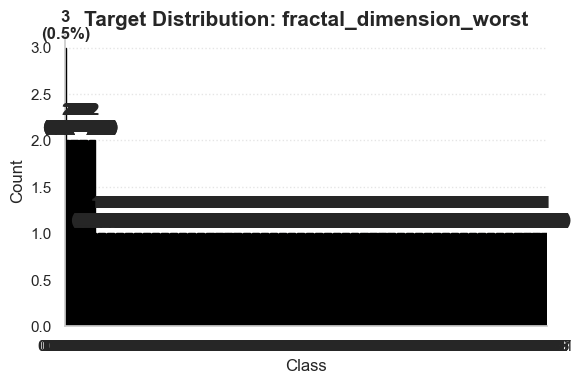

In [53]:
# 1. Load the dataset and show first few rows
df = pd.read_csv('breast-cancer.csv')
display(df.head())
# 2. Show dataset info and missing values
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
# 3. Beautiful Target Distribution Plot
target_col = df.columns[-1]
value_counts = df[target_col].value_counts()
percentages = value_counts / value_counts.sum() * 100
labels = [str(x) for x in value_counts.index]
colors = sns.color_palette('viridis', len(labels))
plt.figure(figsize=(6,4))
ax = sns.barplot(x=labels, y=value_counts.values, palette=colors, edgecolor='black')
for i, (count, pct) in enumerate(zip(value_counts.values, percentages.values)):
    ax.text(i, count + max(value_counts.values)*0.02, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title(f'Target Distribution: {target_col}', fontsize=15, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.savefig('images/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Preprocess Data for SVM

In [54]:

target_col = df.columns[-1]
if df[target_col].nunique() != 2:
    # Try to find a binary column automatically
    for col in df.columns[::-1]:
        if df[col].nunique() == 2:
            target_col = col
            print(f"Auto-selected binary target column: {target_col}")
            break
    else:
        raise ValueError("No binary target column found. Please check your dataset.")

# 2. Encode categorical target if needed
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

# 3. Print class distribution before splitting
print("Class distribution before split:")
print(df[target_col].value_counts())

# 4. Remove classes with less than 3 samples (to ensure at least 2 in train and 1 in test for stratified split)
min_samples_required = 3
class_counts = df[target_col].value_counts()
valid_classes = class_counts[class_counts >= min_samples_required].index
df = df[df[target_col].isin(valid_classes)]

# 5. Print class distribution after filtering
print("Class distribution after filtering:")
print(df[target_col].value_counts())

# 6. Select features and target
X = df.drop(target_col, axis=1)
y = df[target_col]

# 7. Encode all categorical features in X
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 8. Check for single-class edge case
if y.nunique() < 2:
    raise ValueError("Only one class present in the data after filtering. Cannot perform classification.")

# 9. Try to find a valid test_size for stratified split
test_size = 0.2
split_success = False
while test_size > 0.01:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
        split_success = True
        break
    except ValueError as e:
        print(f"test_size={test_size:.2f} failed: {e}")
        test_size -= 0.02
if not split_success:
    # As a last resort, drop classes with less than 4 samples and try again
    print("Reducing classes further to enable stratified split...")
    class_counts = y.value_counts()
    valid_classes = class_counts[class_counts >= 4].index
    X = X[y.isin(valid_classes)]
    y = y[y.isin(valid_classes)]
    if y.nunique() < 2:
        raise ValueError("Only one class present in the data after final filtering. Cannot perform classification.")
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        print("Class distribution after final filtering:")
        print(y.value_counts())
        split_success = True
        test_size = 0.2
    except ValueError as e:
        print("Final stratified split failed. Using random split without stratify.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)
        split_success = True
        test_size = 0.2

# 10. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Used test_size: {test_size:.2f}")

Auto-selected binary target column: diagnosis
Class distribution before split:
diagnosis
0    357
1    212
Name: count, dtype: int64
Class distribution after filtering:
diagnosis
0    357
1    212
Name: count, dtype: int64
Train shape: (455, 31), Test shape: (114, 31), Used test_size: 0.20


### 4. Train SVM with Linear Kernel

In [55]:
# Train SVM with linear kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_linear = svm_linear.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Test Accuracy (Linear Kernel): {acc_linear:.4f}")

Test Accuracy (Linear Kernel): 0.9649


### 5. Train SVM with RBF Kernel

In [56]:
# Train SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rbf = svm_rbf.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Test Accuracy (RBF Kernel): {acc_rbf:.4f}")

Test Accuracy (RBF Kernel): 0.9649


### 6. Visualize Decision Boundary (2D Projection)

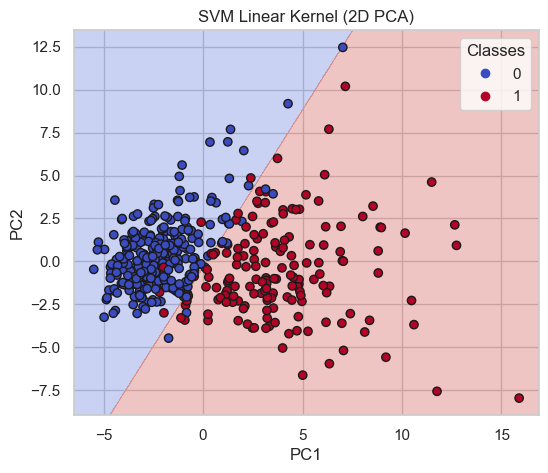

<Figure size 640x480 with 0 Axes>

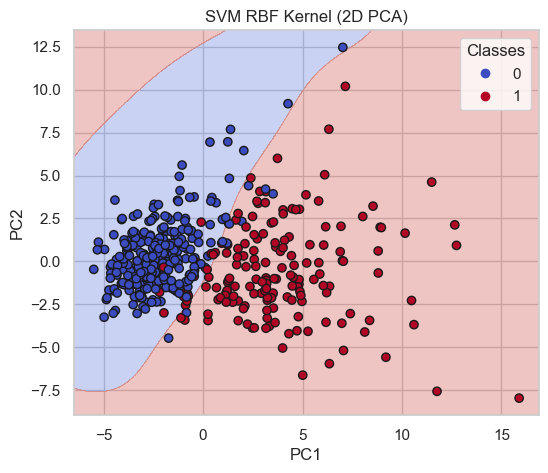

<Figure size 640x480 with 0 Axes>

In [57]:
# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

# Retrain SVMs on 2D data
svm_linear_2d = SVC(kernel='linear', random_state=42).fit(X_train_2d, y_train)
svm_rbf_2d = SVC(kernel='rbf', random_state=42).fit(X_train_2d, y_train)

# Function to plot decision boundary
def plot_decision_boundary(clf, X, y, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# Plot for linear kernel
plot_decision_boundary(svm_linear_2d, X_train_2d, y_train, "SVM Linear Kernel (2D PCA)")
# Plot for RBF kernel
plt.savefig('images/decision_boundary_linear.png', bbox_inches='tight', dpi=150)

plot_decision_boundary(svm_rbf_2d, X_train_2d, y_train, "SVM RBF Kernel (2D PCA)")
plt.savefig('images/decision_boundary_rbf.png', bbox_inches='tight', dpi=150)
plt.show()

### 7. Hyperparameter Tuning (C and gamma)

In [58]:
# Hyperparameter tuning for SVM with RBF kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}
grid = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validated accuracy: {grid.best_score_:.4f}")

Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validated accuracy: 0.9714


### 8. Cross-Validation and Model Evaluation

Cross-validated accuracy (mean ± std): 0.9714 ± 0.0149
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



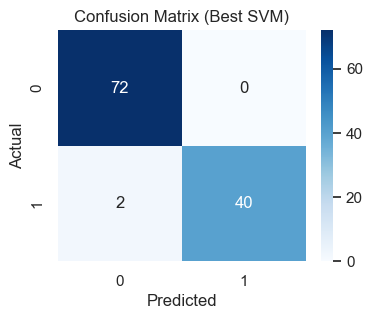

In [59]:
# Evaluate best SVM model from GridSearchCV
best_svm = grid.best_estimator_

# Cross-validation accuracy
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Test set evaluation
best_svm.fit(X_train_scaled, y_train)
y_pred_best = best_svm.predict(X_test_scaled)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred_best)
cr = classification_report(y_test, y_pred_best)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best SVM)')


print('Classification Report:')
print(cr)
# ...existing code for confusion matrix...
plt.savefig('images/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()